# Cognitive model for Facebook behaviour

Authors: Eric Araujo and Dave Ebbelaar


In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# Reload libraries automatically
%load_ext autoreload
%autoreload 2

# Plot in the notebook
%matplotlib inline

In [ ]:


import math

from pprint import pprint

import model

# generate_graph()
Inputs: weightList with ((source,target),weight) values

In [2]:
try:
    edges_f = open('../data/model/model_connections.csv')
    nodes_f = open('../data/model/model_states.csv')
except:
    print("Files absent: connections.csv and states.csv not included in the data folder!")
    sys.exit(0)

In [3]:
# Initiate graph as digraph (oriented graph)
graph = nx.DiGraph()

In [4]:
# Insert nodes
for line in nodes_f:
    # Read each line and split to get nodes' name and function
    node, func = line.replace(" ", "").strip().split(',')
    # Avoiding include repeated nodes
    if node not in graph.nodes():
        # If node is output
        if node in ['like', 'share', 'comment']:
            graph.add_node(node, attr_dict={'pos': 'output', 'func': func, 'status': {}})
        # If node is internal state
        elif func in ['id', 'alogistic']:
            graph.add_node(node, attr_dict={'pos': 'inner', 'func': func, 'status': {}})
        # If node is a trait of the participant
        elif func == 'trait':
            graph.add_node(node, attr_dict={'pos': 'trait', 'func': func, 'status': {}})
        # If node is an input
        elif func == 'input':
            graph.add_node(node, attr_dict={'pos': 'input', 'func': func, 'status': {}})
        else:
            print('Node %s does not match the requirements to create graph.', node)
            sys.exit(0)
    else:
        print('<CONFLICT> Node %s already included in the list!', node)
        sys.exit(0)

In [5]:
outWeightList = []
weightList = None
# Insert edges
if weightList is None:
    for line in edges_f:
        source, target, w = line.replace(" ", "").strip().split(',')

        graph.add_edge(source, target, weight=float(w))
        outWeightList.append(((source, target), float(w)))
# In case you have changes in the edges over time.
else:
    for line in weightList:
        ((source, target), w) = line
        graph.add_edge(source, target, weight=float(w))
        outWeightList.append(((source, target), float(w)))

In [6]:
print("Graph generated successfully. It contains {} nodes and {} edges.".format(
        graph.number_of_nodes(),graph.number_of_edges()))

Graph generated successfully. It contains 62 nodes and 77 edges.


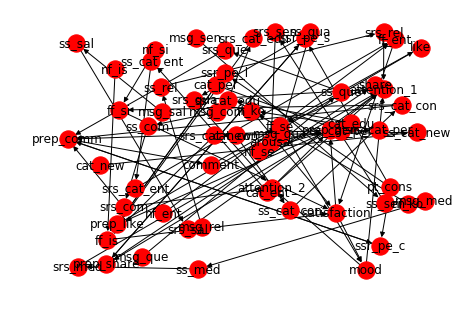

In [7]:
nx.draw_random(graph, with_labels=True)
plt.draw()

# run_message()

In [8]:
import lib.messages.generate_messages as gm

In [9]:
messages_df = gm.sequence_messages()

In [10]:
message=None
agent=None
traits=None
previous_status_dict=None
alogistic_parameters=None
speed_factor=0.5
delta_t=1
timesteps=30
weightList=None

In [11]:
messages_dict = dict(messages_df.T)

In [12]:
# Number of messages
len(messages_dict)

250

In [13]:
message = messages_dict[0]

In [14]:
message

cat_con    0.0
cat_edu    0.0
cat_ent    0.0
cat_new    1.0
cat_per    0.0
msg_com    0.0
msg_med    0.5
msg_qua    0.5
msg_que    0.0
msg_rel    1.0
msg_sen    1.0
Name: 0, dtype: float64

In [15]:
json_string = "../data/agents/agents.json"
with open(json_string, 'r') as f:
    agents = json.load(f)

In [16]:
agents

{'1': {'nf_ko': 0.5,
  'nf_ent': 0.5,
  'nf_is': 0.5,
  'nf_si': 0.5,
  'nf_se': 0.5,
  'pt_con': 0.1},
 '2': {'nf_ko': 0.5,
  'nf_ent': 0.9,
  'nf_is': 0.5,
  'nf_si': 0.5,
  'nf_se': 0.5,
  'pt_con': 0.5},
 '3': {'nf_ko': 0.5,
  'nf_ent': 0.5,
  'nf_is': 0.5,
  'nf_si': 0.5,
  'nf_se': 0.5,
  'pt_con': 0.9}}

In [17]:
agent='1'

In [18]:
# Read the json file with the alogistic parameters
if alogistic_parameters is None:
    try:
        with open('../data/model/alogistic_parameters.json') as data_file:    
            alogistic_parameters = json.load(data_file)
    except:
        print('Couldn\'t read the alogistic parameters! Check the \'alogistic.json\' file!')
        sys.exit()
elif alogistic_parameters == 'random':
    alogistic_parameters = {
                 "srs_sal": [random()*10, random()*20],
                 "arousal": [0.45, random()*20],
                 "attention_1": [2.23, random()*20],
                 "attention_2": [0.23, random()*20],
                 "mood": [5.3, random()*20],
                 "ff_ko": [1.75, random()*20],
                 "ff_ent": [1.43, random()*20],
                 "ff_si": [1.12, random()*20],
                 "ff_is": [2.04, random()*20],
                 "ff_se": [2.45, random()*20],
                 "satisfaction": [2.1, random()*20],
                 "prep_like" : [2.8,random()*20],
                 "prep_comm": [3.5,random()*20],
                 "prep_share" : [2.1, random()*20],
                 "mood_speed": random()
                }

In [19]:
alogistic_parameters

{'srs_sal': [0.7, 2],
 'arousal': [0.9, 2],
 'attention_1': [2.8, 2],
 'attention_2': [0.5, 5],
 'mood': [1.4, 2],
 'ff_ko': [1.4, 2],
 'ff_ent': [1.4, 2],
 'ff_si': [1.4, 4],
 'ff_is': [2.1, 4],
 'ff_se': [2.8, 2],
 'satisfaction': [1.0, 5],
 'prep_like': [2.8, 2],
 'prep_comm': [3.5, 2],
 'prep_share': [2.1, 3],
 'mood_speed': 0.01}

In [20]:
rng = np.arange(0.0, timesteps*delta_t, delta_t)
pos = None

In [21]:
message

cat_con    0.0
cat_edu    0.0
cat_ent    0.0
cat_new    1.0
cat_per    0.0
msg_com    0.0
msg_med    0.5
msg_qua    0.5
msg_que    0.0
msg_rel    1.0
msg_sen    1.0
Name: 0, dtype: float64

In [23]:
for t in rng:
    # Initialize the nodes on time 0
    if t == 0:
        for node in graph.nodes():
            try:
                func = graph.nodes[node]['attr_dict']['func']
                pos = graph.nodes[node]['attr_dict']['pos']
                #print(node, func, pos)
            except:
                print('node without func or pos %s at time %i' % (node, t))

            # Inputs receive a stable value for all the timesteps
            # message[0] is the time of the message
            if pos == 'input':
                if node == 'cat_per':
                    graph.nodes[node]['status'] = {0:message['cat_per']}
                elif node == 'cat_ent':
                    graph.nodes[node]['status'] = {0:message['cat_ent']}
                elif node == 'cat_new':
                    graph.nodes[node]['status'] = {0:message['cat_new']}
                elif node == 'cat_edu':
                    graph.nodes[node]['status'] = {0:message['cat_edu']}
                elif node == 'cat_con':
                    graph.nodes[node]['status'] = {0:message['cat_con']}
                elif node == 'msg_rel':
                    graph.nodes[node]['status'] = {0:message['msg_rel']}
                elif node == 'msg_qua':
                    graph.nodes[node]['status'] = {0:message['msg_qua']}
                elif node == 'msg_sen':
                    graph.nodes[node]['status'] = {0:message['msg_sen']}
                elif node == 'msg_sal':
                    graph.nodes[node]['status'] = {0:message['msg_sal']}
                elif node == 'msg_med':
                    graph.nodes[node]['status'] = {0:message['msg_med']}
                elif node == 'msg_com':
                    graph.nodes[node]['status'] = {0:message['msg_com']}
                elif node == 'msg_que':
                    graph.nodes[node]['status'] = {0:message['msg_que']}
                else:
                    print('Node with wrong value:', node)
                    sys.exit()
            # states are the personality traits of the agent
            elif node == 'nf_ko':
                graph.nodes[node]['status'] = {0:traits[agent]['nf_ko']}
            elif node == 'nf_ent':
                graph.nodes[node]['status'] = {0:traits[agent]['nf_ent']}
            elif node == 'nf_is':
                graph.nodes[node]['status'] = {0:traits[agent]['nf_is']}
            elif node == 'nf_si':
                graph.nodes[node]['status'] = {0:traits[agent]['nf_si']}
            elif node == 'nf_se':
                graph.nodes[node]['status'] = {0:traits[agent]['nf_se']}      
            elif node == 'pt_cons':
                graph.nodes[node]['status'] = {0:traits[agent]['pt_cons']}
            elif node == 'mood':
                graph.nodes[node]['status'] = {0:traits[agent]['mood']}
            # The other states are set to previous values at the beginning
            else:
                if previous_status_dict is None:
                    graph.nodes[node]['status'] = {0:0}
                # Keeping the state of the nodes from previous timestep
                else:
                    graph.nodes[node]['status'] = {0:previous_status_dict[node]}
        continue

KeyError: 'msg_sal'